In [ ]:
#  
#  The objective is to find the instrumentation(s) that predict/quantify the efficiency of the cooler, a component on the
#  hydraluic rig whose schematics is depicted in the associated article. The hydraulic rig,a mock up, has redundant
#  instrumentations installed.
#
#  This code runs on the file 'Data for SFS.csv' which is a second stage extraction from a larger dataset file prepared from 
#  the original raw data posted on the UCI Machine Learning Repository(https://archive.ics.uci.edu/)-'Condition' Monitoring
#  of Hydraulic Systems'. 'Data for SFS.csv' is composed of raw sensor readings, at a load setting of 151 Bar
#  (load sequence 11), as well as features derived from these raw readings.The derived features consist of either two or 
#  three raw sensor readings. The maximun number of selected instrumentations is limited to three.
#  
#  These features, in most cases, correspond to a physical/engineering parameter such as heat lost across heat exchanger- 
#  dT-Cooler *FS2,or work done on fluid across heat exchanger- dP-Cooler * FS2 or power consumption per unit of temperature 
#  difference - Pw/(TS4-Ta),etc.
#
#  Three groupings of features are defined depending on the number of constituent raw sensor readings: single, dual, triple
#
#  The function sfs_bymetrics is an implementation of the SequentialFeatureSelector(SFS) with the RidgeCV(can also be 
#  LassoCV) as estimator.In this implementation the SFS uses "max_error" as its metric.
#
#  The find_features function, loops through tol_err, a list of "max_error" thresholds,to call the sfs_bymetrics function,in 
#  order to find features that improve the prediction error by, at minimum,the corresponding "max_error". The function,after 
#  performing the first run on all values in tol_err,removes the selected feature(s) and performs a re-run to find other 
#  (runner-up) features.Such re-runs are done upto,but not necessarily,three times. This is done for each grouping.
# 
#  Ordinary least square(OLS) regression is then run on the selected features.Final comparative review is made on plots of
#            i- r-squared vs Mean Absolute Error
#           ii- Absolute Error(in Efficiency units) distribution 
#          iii- predicted vs actual cooler efficiency based on each of the selected features. 
#  

In [1]:
#Importing the libraries...

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import RidgeCV,Ridge,LassoCV
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Initialisations....

datafile = "Data for SFS.csv"
max_number_of_instrumentations = 3
selection_metric = 'max_error'
estimator= 'RidgeCV'                                           # Could be LassoCV
tol_err = [0.3,0.2,0.1,0.08,0.06,0.03,0.01]                    # max error improvement 
z = 1.96                                                       # Significance level of 95%

#r-sqrd and average error(MAE) for the OLS regression on each selected feature is stored in the list metrics_ols
metrics_ols = pd.DataFrame(columns = ['Feature','r-squared','MAE']) 

#Absolute error from the OLS regression for each feature is stored in AbsoluteError
AbsoluteError = pd.DataFrame()

prediction_interval = pd.DataFrame(index=['Absolute Error-Scaled','Absolute Error-Efficiency'])

In [3]:
# Estimator selection and initialisations...

def estimator_def(selected_estimator):
    if selected_estimator == 'RidgeCV':
            estimator=RidgeCV(alphas= [1,0.1,0.5,0.001,0.0001])
    elif selected_estimator == 'LassoCV':
           estimator=LassoCV(alphas = [1,0.1,0.5,0.001,0.0001],max_iter=100000)
    return estimator

In [4]:
#Standard scaling

def scale (data):
    
    scaler=StandardScaler() 
    
    return scaler.fit_transform(data)

In [5]:
# Standard scaling with metrics returned. The mean and stanard deviations values shall be used to convert absolute errors,
# which are in scaled units, to efficiency units(%). Refer Sklearn documentation for details.

def scale_withmetric (data):
    
    scaler = StandardScaler() 
    scaled_data = scaler.fit_transform(data)
    mean = scaler.mean_
    std_dev = scaler.scale_
    
    return scaled_data, mean, std_dev

In [6]:
#Split into train and test

def split (predictor, target):
    
    data_train, data_test,target_train,target_test = train_test_split(predictor,target,test_size=0.25, shuffle=True)  
    
    return data_train, data_test,target_train,target_test

In [7]:
# This function uses SequentialFeatureSelection from the sklearn library to select features(instrumentations or group of). 
# Features improving the maximum prediction error by,at minimum the specified threhold, will be selected.

def sfs_bymetric (instruments_reading,cooler_efficiency,estimator,threshold):
    sfs = SequentialFeatureSelector(estimator,tol = threshold,scoring = selection_metric)
    sfs.fit(instruments_reading,cooler_efficiency)
    
    return sfs.support_            # returns a list of booleans for each feature indicating selection(or not)

In [8]:
#  This function will use the above function,sfs_bymetric,to iterate through tol_err,a list of error thresholds.
#  The output will hence be a list of lists of selected features corresponding to each error threhold in tol_err.

def find_features(instrument,fault,max_nofeatures):              
    
    selected_features = []         # list of lists of selected features
        
    for error in tol_err:
        sub_selection = []                       # represents a list of selected features for an error threshold in toL_err
       
        # find nonzero indices i.e. selected features
        indices = np.nonzero(sfs_bymetric(instrument,fault,estimator_def(estimator),error))[0]
        
        if len(indices) > max_nofeatures:                                                          
            break
        for item in indices:
            sub_selection.append(instrument.columns[item])                       
        selected_features.append(sub_selection)                    
        
    final_selection = list(zip(tol_err,selected_features))      
    
    return final_selection

In [9]:
# OLS regression; Computation of r-squared and MAE; Updating the AbsoluteError and metrics_ols dataframes with 
# computed r-squared and MAE.

def ols_regress_metrics(features):    
 
    data_train = instrument_train_scaled[features]   
    data_test = instrument_test_scaled[features]
    reg = LinearRegression().fit(data_train,fault_train_scaled)
    
    # R-square and MAE computation. abs_error is a list of errors for each data point in test set.
    r_sqrd = reg.score(instrument_train_scaled[features],fault_train_scaled)                             
    avg_error = mean_absolute_error(fault_test_scaled,reg.predict(instrument_test_scaled[features]))    
    abs_error = fault_test_scaled-reg.predict(instrument_test_scaled[features]) 
    
    # Prediction Interval computation
    sqrd_err = np.square(abs_error)
    sum_sqrd_err = sqrd_err[0].sum() 
    std_err = math.sqrt(1/(len(abs_error)-2) * sum_sqrd_err)
    pred_interval = z * std_err
        
    # Storing...
    AbsoluteError[features[0]] =  abs_error
    prediction_interval.loc['Absolute Error-Scaled', features[0]] = pred_interval
    metrics_ols.loc[len(metrics_ols.index)] = [features[0],r_sqrd,avg_error]
        
    return  reg

In [10]:
## Plot actual vs predicted efficiency(in scaled units) on the test dataset.

def plot_linear (reg,features):
    
    plt.figure(figsize = (4, 3))
        
    plt.scatter(fault_test_scaled,reg.predict(instrument_test_scaled[features]))
    x = [-2,-1,0,1,2]
    y = [-2,-1,0,1,2]
    plt_title = 'Prediction on Test Set ' + str('['+ features[0] +']')
    plt.title(plt_title)
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.plot(x,y, color='r')
    plt.grid()
    
    plt.show()    

In [11]:
#Load data from file....
all_data = pd.read_csv(datafile)
all_data.head()

,Unnamed: 0,Cooler,PS1,Pw,TS1,TS3,TS4,FS2,CoolerEff,Ta,...,Pw/TS1,Pw/dT-Cooler,Pw/PS6*FS2,TS4/dT-Cooler,Pw/(TS4-Ta),Pw/(TS1-Ta),Pw/dP-Cooler,Pw*Ta/PS6SMTH,PS1 * Ta/PS6SMTH,Pw/TS4*FS2
0,12760,3,151.47,2368.4,54.465,55.723,49.672,9.206,19.495,24.684272,...,43.484807,391.406379,-3249.725576,8.208891,94.782527,79.527942,42217.468806,6896.408023,441.056799,58.528147
1,12761,3,152.72,2364.0,54.402,55.816,49.656,9.196,19.676,24.508824,...,43.454285,383.766234,-3291.103996,8.061039,94.006579,79.081593,42289.803220,6834.266291,441.509792,58.428077
2,12762,3,151.32,2359.4,54.418,55.816,49.582,9.206,19.889,24.472041,...,43.356977,378.472891,-3241.824677,7.953481,93.962718,78.788594,41982.206406,6810.329268,436.780124,58.435704
3,12763,3,151.34,2357.8,54.336,55.809,49.613,9.203,19.964,24.773135,...,43.392962,380.535830,-3274.267463,8.007263,94.920002,79.755465,42254.480287,6885.628588,441.967525,58.346944
4,12764,3,152.19,2361.0,54.324,55.816,49.578,9.169,19.944,24.538423,...,43.461454,378.486694,-3456.808199,7.947740,94.290729,79.266552,42160.714286,6827.152509,440.078077,58.427578


In [12]:
#Splitting into dependent and independent variables... 

cooler_fault = all_data[['Cooler']]
parameters = all_data.drop(columns=['Unnamed: 0','Cooler'])

In [13]:
#Splitting into test and train data...
instrument_train,instrument_test,fault_train,fault_test = train_test_split(parameters,cooler_fault)

In [14]:
# Standardising test and training data...

instrument_train_scaled = pd.DataFrame(scale(instrument_train), columns=parameters.columns)
instrument_test_scaled =  pd.DataFrame(scale(instrument_test),columns=parameters.columns)
fault_train_scaled = pd.DataFrame(scale(fault_train))

scaled_fault_test, avg_fault_test, stddev_fault_test = scale_withmetric(fault_test)
fault_test_scaled =  pd.DataFrame(scaled_fault_test)

In [15]:
#Splitting into single,dual and triple-instrumented features

single_scaled = instrument_train_scaled[['PS1','Pw', 'TS1','TS3','TS4','FS2','Ta','PS5_SMTH','PS6_SMTH']]
dual_scaled = instrument_train_scaled[['TS4/Ta', 'FS2/Ta', 'PS5_SMTH/Ta','dT-Cooler','dP-Cooler','Pw/TS4',
                                       'Pw/Ta','Pw/FS2','Pw/PS5_SMTH','TS4/dT-Cooler']]
triple_scaled = instrument_train_scaled[['CoolerEff', 'dPCooler_SMTH/Ta', 'dPCooler_SMTH*FS2', 'TS4*FS2/Ta', 
                                         'PS6_SMTH*FS2/Ta', 'dT-Cooler/Ta', 'dT-Cooler * FS2','Pw/dT-Cooler',
                                         'Pw/(TS4-Ta)','Pw/(TS1-Ta)','Pw/dP-Cooler','Pw/PS6*FS2']]

In [16]:
# First run to identify features of single instrumented features(raw sensor readings).

firstrun_single = pd.DataFrame(find_features(single_scaled,fault_train_scaled,max_number_of_instrumentations),
                             columns=['Metric Improvement','Features'])
print(firstrun_single.to_string(index=False))    

 Metric Improvement             Features
               0.30           [PS6_SMTH]
               0.20           [PS6_SMTH]
               0.10      [TS3, PS6_SMTH]
               0.08      [TS3, PS6_SMTH]
               0.06      [TS3, PS6_SMTH]
               0.03      [TS3, PS6_SMTH]
               0.01 [TS3, TS4, PS6_SMTH]


In [17]:
# Second run after removing selected feature from first run.
# Single instrumented features after removal are: ['PS1','Pw','TS1','TS4','FS2','Ta','PS5_SMTH']

secondrun_single = pd.DataFrame(find_features(single_scaled.drop(columns=['TS3', 'PS6_SMTH']),
                              fault_train_scaled,max_number_of_instrumentations),
                              columns=['Metric Improvement','Features'])
print(secondrun_single.to_string(index=False))  

 Metric Improvement             Features
               0.30           [PS5_SMTH]
               0.20           [PS5_SMTH]
               0.10      [TS1, PS5_SMTH]
               0.08      [TS1, PS5_SMTH]
               0.06      [TS1, PS5_SMTH]
               0.03      [TS1, PS5_SMTH]
               0.01 [TS1, TS4, PS5_SMTH]


In [18]:
# Third run on single instrumented features after removing features selected from previous two runs. 
# Single instrumented features after two-step removal: ['PS1','Pw', 'TS1','TS4','FS2','Ta']

thirdrun_single = pd.DataFrame(find_features(single_scaled.drop(columns=['TS1', 'PS6_SMTH','TS3', 'PS5_SMTH']),
                              fault_train_scaled,max_number_of_instrumentations),
                             columns=['Metric Improvement','Features'])
print(thirdrun_single.to_string(index=False))  

 Metric Improvement Features
               0.30    [TS4]
               0.20    [TS4]
               0.10    [TS4]
               0.08    [TS4]
               0.06    [TS4]
               0.03    [TS4]
               0.01    [TS4]


In [19]:
#Running OLS regression

PS6_reg = ols_regress_metrics(['PS6_SMTH','TS1'])
PS5_reg = ols_regress_metrics(['PS5_SMTH','TS3'])

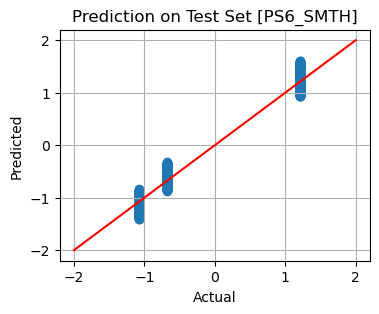

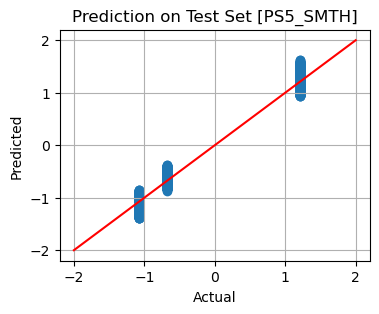

In [20]:
#Plotting actual vs predicted cooler efficiencies in scaled units...

plot_linear(PS6_reg,['PS6_SMTH','TS1'])
plot_linear(PS5_reg,[ 'PS5_SMTH','TS3'])

In [21]:
# First selection run on dual-instrumented group...

firstrun_dual = pd.DataFrame(find_features(dual_scaled,fault_train_scaled,max_number_of_instrumentations-1),
                             columns = ['Metric Improvement','Features'])
print(firstrun_dual.to_string(index=False))

 Metric Improvement         Features
               0.30         [Pw/TS4]
               0.20         [Pw/TS4]
               0.10 [FS2/Ta, Pw/TS4]
               0.08 [FS2/Ta, Pw/TS4]
               0.06 [FS2/Ta, Pw/TS4]


In [22]:
#Second run after dropping selected feature...

secondrun_dual = pd.DataFrame(find_features(dual_scaled.drop(columns = ['Pw/TS4']),fault_train_scaled,
                                          max_number_of_instrumentations-1),columns = ['Metric Improvement','Features'])         
print(secondrun_dual.to_string(index=False))

 Metric Improvement    Features
               0.30 [dT-Cooler]
               0.20 [dT-Cooler]
               0.10 [dT-Cooler]
               0.08 [dT-Cooler]
               0.06 [dT-Cooler]


In [23]:
#Third run...

thirdrun_dual = pd.DataFrame(find_features(dual_scaled.drop(columns=['dT-Cooler','Pw/TS4']), fault_train_scaled,
                         max_number_of_instrumentations-1),columns=['Metric Improvement','Pw/TS4, dT-Cooler removed'])
print(thirdrun_dual.to_string(index=False))

 Metric Improvement Pw/TS4, dT-Cooler removed
               0.30                  [TS4/Ta]
               0.20                  [TS4/Ta]
               0.10                  [TS4/Ta]
               0.08                  [TS4/Ta]
               0.06                  [TS4/Ta]
               0.03                  [TS4/Ta]


In [24]:
#Summary on dual instrumentation runs

thirdrun_dual.insert(1,"All Features",firstrun_dual['Features'])
thirdrun_dual.insert(2,"dT-Cooler Rmvd",secondrun_dual['Features'])
print(thirdrun_dual.to_string(index=False,col_space=28))

          Metric Improvement                 All Features               dT-Cooler Rmvd    Pw/TS4, dT-Cooler removed
                        0.30                     [Pw/TS4]                  [dT-Cooler]                     [TS4/Ta]
                        0.20                     [Pw/TS4]                  [dT-Cooler]                     [TS4/Ta]
                        0.10             [FS2/Ta, Pw/TS4]                  [dT-Cooler]                     [TS4/Ta]
                        0.08             [FS2/Ta, Pw/TS4]                  [dT-Cooler]                     [TS4/Ta]
                        0.06             [FS2/Ta, Pw/TS4]                  [dT-Cooler]                     [TS4/Ta]
                        0.03                          NaN                          NaN                     [TS4/Ta]


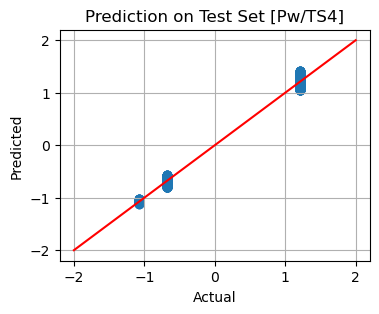

In [25]:
#Run OLS regression on selected features and plot actual vs predicted on scaled units...

PWTS4 = ols_regress_metrics(['Pw/TS4','Pw','TS4'])
plot_linear(PWTS4,['Pw/TS4','Pw','TS4'])

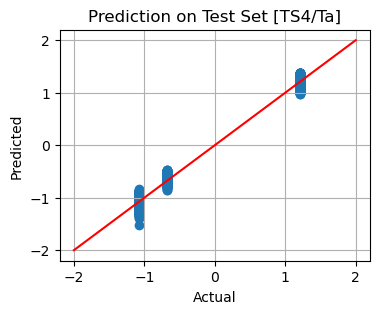

In [26]:
# Run OLS regression and plotting actual vs predicted values in scaled units...

TS4Ta = ols_regress_metrics(['TS4/Ta','Ta','TS4'])
plot_linear(TS4Ta,['TS4/Ta','Ta','TS4'])

In [27]:
#dT-Cooler was found to have high prediction errors and is hence excluded.
'''dT_Cooler=ols_regress_metrics(['dT-Cooler','TS4','TS3'])
plot_linear(dT_Cooler,['dT-Cooler','TS4','TS3'])'''

"dT_Cooler=ols_regress_metrics(['dT-Cooler','TS4','TS3'])\nplot_linear(dT_Cooler,['dT-Cooler','TS4','TS3'])"

In [28]:
#First run on triple-instrumented features...

firstrun_triple = pd.DataFrame(find_features(triple_scaled,fault_train_scaled,max_number_of_instrumentations-1),
                             columns=['Metric Improvement','Features'])
print(firstrun_triple.to_string(index=False))

 Metric Improvement      Features
               0.30 [Pw/(TS4-Ta)]
               0.20 [Pw/(TS4-Ta)]
               0.10 [Pw/(TS4-Ta)]
               0.08 [Pw/(TS4-Ta)]
               0.06 [Pw/(TS4-Ta)]
               0.03 [Pw/(TS4-Ta)]
               0.01 [Pw/(TS4-Ta)]


In [29]:
# Second run on triple-instrumented features after removal of feature selected at first run

secondrun_triple = pd.DataFrame(find_features(triple_scaled.drop(columns=['Pw/(TS4-Ta)']),fault_train_scaled,
                                            max_number_of_instrumentations-1),columns=['Metric Improvement','Features'])
print(secondrun_triple.to_string(index=False))

 Metric Improvement    Features
               0.30 [CoolerEff]
               0.20 [CoolerEff]
               0.10 [CoolerEff]
               0.08 [CoolerEff]
               0.06 [CoolerEff]


In [30]:
#Third run...

thirdrun_triple = pd.DataFrame(find_features(triple_scaled.drop(columns=['Pw/(TS4-Ta)','CoolerEff']),fault_train_scaled,
                               max_number_of_instrumentations-1),columns=['Metric Improvement','Features'])
print(thirdrun_triple.to_string(index=False))

 Metric Improvement      Features
               0.30 [Pw/(TS1-Ta)]
               0.20 [Pw/(TS1-Ta)]
               0.10 [Pw/(TS1-Ta)]
               0.08 [Pw/(TS1-Ta)]
               0.06 [Pw/(TS1-Ta)]


In [31]:
#Fourth run...
fourthrun_triple = pd.DataFrame(find_features(triple_scaled.drop(columns=['Pw/(TS4-Ta)','CoolerEff','Pw/(TS1-Ta)']),
                                           fault_train_scaled,max_number_of_instrumentations-1),
                                           columns=['Improvement','Pw/(TS4-Ta),Pw/(TS1-Ta), CoolerEff Rmvd'])
print(fourthrun_triple.to_string(index=False))

 Improvement Pw/(TS4-Ta),Pw/(TS1-Ta), CoolerEff Rmvd
        0.30                            [TS4*FS2/Ta]
        0.20                            [TS4*FS2/Ta]
        0.10                [TS4*FS2/Ta, Pw/PS6*FS2]
        0.08                [TS4*FS2/Ta, Pw/PS6*FS2]
        0.06                [TS4*FS2/Ta, Pw/PS6*FS2]


In [32]:
#Summarising triple-instrumentation feature selection
fourthrun_triple.insert(1,"All Features",firstrun_triple['Features'])
fourthrun_triple.insert(2,"Pw/(TS4-Ta) Rmvd",secondrun_triple['Features'])
fourthrun_triple.insert(3,"Pw/(TS4-Ta),CoolerEff Rmvd",thirdrun_triple['Features'])
print(fourthrun_triple.to_string(index=False,col_space=14))

   Improvement   All Features Pw/(TS4-Ta) Rmvd Pw/(TS4-Ta),CoolerEff Rmvd Pw/(TS4-Ta),Pw/(TS1-Ta), CoolerEff Rmvd
          0.30  [Pw/(TS4-Ta)]      [CoolerEff]              [Pw/(TS1-Ta)]                            [TS4*FS2/Ta]
          0.20  [Pw/(TS4-Ta)]      [CoolerEff]              [Pw/(TS1-Ta)]                            [TS4*FS2/Ta]
          0.10  [Pw/(TS4-Ta)]      [CoolerEff]              [Pw/(TS1-Ta)]                [TS4*FS2/Ta, Pw/PS6*FS2]
          0.08  [Pw/(TS4-Ta)]      [CoolerEff]              [Pw/(TS1-Ta)]                [TS4*FS2/Ta, Pw/PS6*FS2]
          0.06  [Pw/(TS4-Ta)]      [CoolerEff]              [Pw/(TS1-Ta)]                [TS4*FS2/Ta, Pw/PS6*FS2]


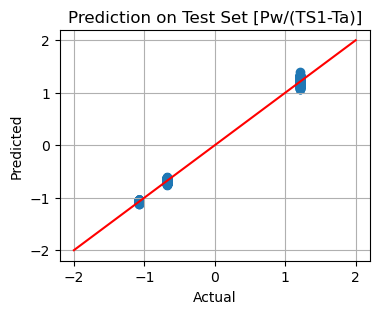

In [33]:
PWTS1Ta = ols_regress_metrics(['Pw/(TS1-Ta)','TS1','Ta','Pw'])
plot_linear(PWTS1Ta,['Pw/(TS1-Ta)','TS1','Ta','Pw'])

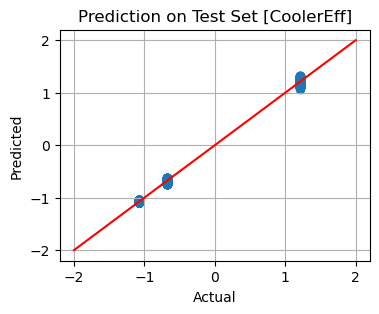

In [34]:
CoolerEff = ols_regress_metrics(['CoolerEff','TS4','TS3','Ta'])
plot_linear(CoolerEff,['CoolerEff','TS4','TS3','Ta'])

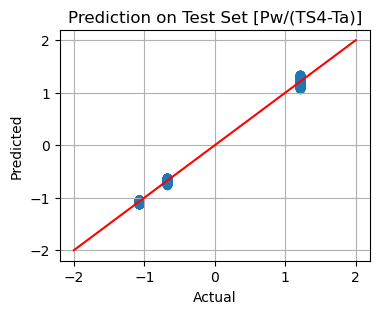

In [35]:
PWTS4Ta = ols_regress_metrics(['Pw/(TS4-Ta)','Ta','TS4','Pw'])
plot_linear(PWTS4Ta,['Pw/(TS4-Ta)','Ta','TS4','Pw'])

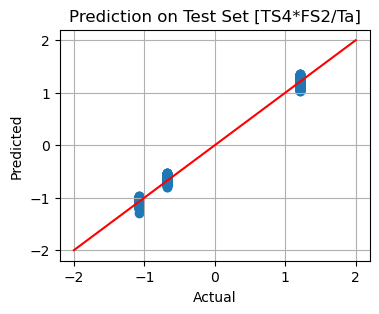

In [36]:
TS4FS2 = ols_regress_metrics(['TS4*FS2/Ta','TS4','FS2','Ta'])
plot_linear(TS4FS2,['TS4*FS2/Ta','TS4','FS2','Ta'])

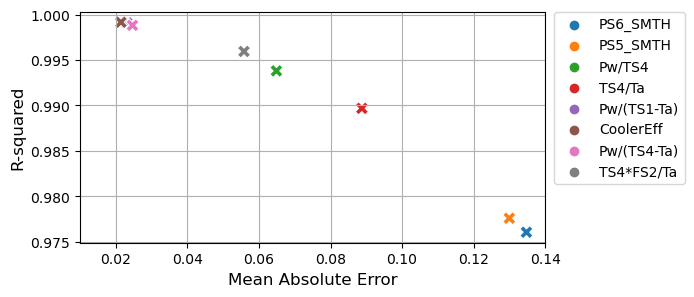

In [37]:
#Plot respective r-squared and MAE(Mean Average Error) for each of the selected instrumentations.

plt.figure(figsize=(6, 3))
sns.scatterplot( x = 'MAE', y = 'r-squared', hue = 'Feature',data=metrics_ols,s=90,marker='X')
plt.xlim(left = 0.01,right=0.14)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylabel('R-squared',fontsize=12)
plt.xlabel('Mean Absolute Error',fontsize=12)
plt.grid()

plt.show()

In [38]:
# Converting the prediction error to units of efficiency

prediction_interval.loc['Absolute Error-Efficiency',:]= prediction_interval.loc['Absolute Error-Scaled',:]*stddev_fault_test

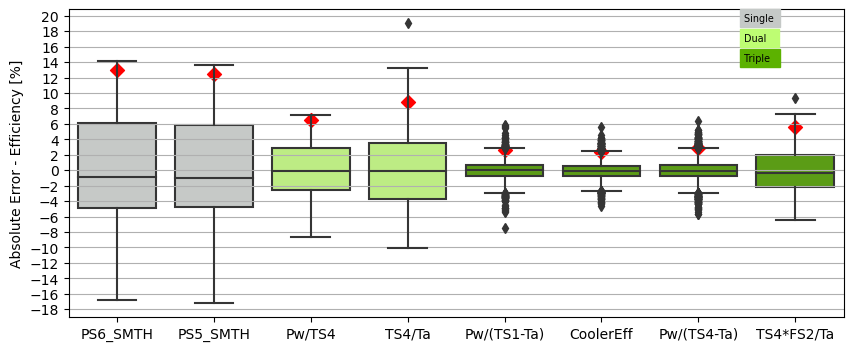

In [39]:
#Plot error distribution for the selected features..

fig, ax = plt.subplots(figsize=(10, 4))
#plt.title('Absoulte Error Distribution')
ytik=(np.array(range(-20,20)))
plt.yticks(ytik*2)
plt.ylabel("Absolute Error - Efficiency [%]")

plt.grid(which = 'both')
group_color = {"PS5_SMTH":sns.xkcd_rgb['silver'],"PS6_SMTH":sns.xkcd_rgb['silver'],
             "Pw/TS4":sns.xkcd_rgb['pale lime'], "TS4/Ta":sns.xkcd_rgb['pale lime'],
             "Pw/(TS1-Ta)":sns.xkcd_rgb['kermit green'],"CoolerEff":sns.xkcd_rgb['kermit green'],
             "Pw/(TS4-Ta)":sns.xkcd_rgb['kermit green'],"TS4*FS2/Ta":sns.xkcd_rgb['kermit green']}


error_plot = sns.boxplot(AbsoluteError.mul(stddev_fault_test[0]),palette=group_color)   
plt.scatter(prediction_interval.columns,prediction_interval.loc['Absolute Error-Efficiency',:],
            color='r',marker='D',s=50)

fig.text(0.80, 0.85,"Single ",backgroundcolor = sns.xkcd_rgb['silver'],color='black', weight='roman', size='x-small' )
fig.text(0.80, 0.80,"Dual   ",backgroundcolor = sns.xkcd_rgb['pale lime'],color='black', weight='roman', size='x-small' )
fig.text(0.80, 0.75,"Triple  ",backgroundcolor =sns.xkcd_rgb['kermit green'],color='black', weight='roman', size='x-small' )
plt.show()

In [40]:
# A complete run on all features regardles of number of instrumentations...

all_first_run = pd.DataFrame(find_features(instrument_train_scaled,fault_train_scaled,max_number_of_instrumentations),
                             columns=['Metric Improvement','Features'])
print(all_first_run.to_string(index=False))    

 Metric Improvement          Features
               0.30     [Pw/(TS4-Ta)]
               0.20     [Pw/(TS4-Ta)]
               0.10     [Pw/(TS4-Ta)]
               0.08     [Pw/(TS4-Ta)]
               0.06     [Pw/(TS4-Ta)]
               0.03     [Pw/(TS4-Ta)]
               0.01 [Pw, Pw/(TS4-Ta)]


In [41]:
# Second run on all features after removing first selection...

all_second_run = pd.DataFrame(find_features(instrument_train_scaled.drop(columns=['Pw/(TS4-Ta)']),fault_train_scaled,
                                               max_number_of_instrumentations),columns=['Metric Improvement','Features'])
print(all_second_run.to_string(index=False)) 

 Metric Improvement                                     Features
               0.30                                  [CoolerEff]
               0.20                                  [CoolerEff]
               0.10                   [CoolerEff, TS4/dT-Cooler]
               0.08                   [CoolerEff, TS4/dT-Cooler]
               0.06                   [CoolerEff, TS4/dT-Cooler]
               0.03                   [CoolerEff, TS4/dT-Cooler]
               0.01 [CoolerEff, TS4/dT-Cooler, PS1 * Ta/PS6SMTH]


In [42]:
prediction_interval

,PS6_SMTH,PS5_SMTH,Pw/TS4,TS4/Ta,Pw/(TS1-Ta),CoolerEff,Pw/(TS4-Ta),TS4*FS2/Ta
Absolute Error-Scaled,0.304547,0.293090,0.152283,0.208241,0.060512,0.056543,0.066699,0.133155
Absolute Error-Efficiency,12.939545,12.452768,6.470186,8.847716,2.571015,2.402385,2.833913,5.657458
